# Hamiltonian Monte Carlo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import patsy as pt

## Toy Model

In [2]:
mu = np.zeros(2)
S = np.identity(2)
r = -0.75
S[0,1] = S[1,0] = r
S

array([[ 1.  , -0.75],
       [-0.75,  1.  ]])

In [3]:
MvN = st.multivariate_normal(mean = mu, cov = S)
x = MvN.rvs(size = 301)

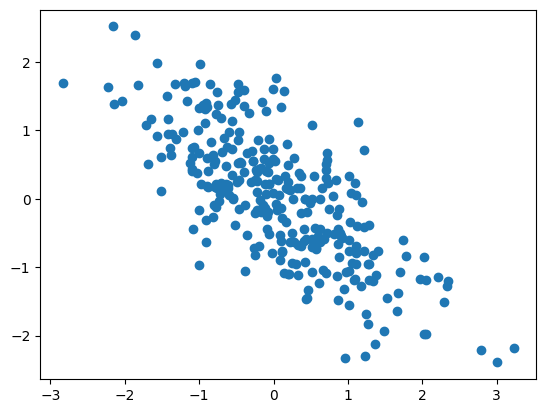

In [4]:
plt.scatter(x[:, 0], x[:, 1]);

In [5]:
def normal_ll(theta, data):
    mu = data["mu"]
    S = data["S"]
    return st.multivariate_normal(mean = mu, cov = S).logpdf(theta)

def grad_normal_ll(theta, data):
    x = theta[0]
    y = theta[1]
    r = data["r"]
    odomr2 = 1 / (1 - r * r)
    dx = -(x - r * y) * odomr2
    dy = -(y - r * x) * odomr2
    return np.array([dx, dy])

### Metropolis (on toy model)

In [6]:
def metropolis_step(theta, logf, data, stepsize, rng):
    thetastar = rng.normal(loc = theta, scale = stepsize, size = np.shape(theta))
    r = np.minimum(0, logf(thetastar, data) - logf(theta, data))
    u = np.log(rng.uniform())
    if u < r:
        theta = thetastar
    return theta

In [17]:
rng = np.random.default_rng()
M = 10_000
mu = np.zeros(2)
S = np.identity(2)
r = -0.75
S[0,1] = S[1,0] = r
data = {"r": r, "mu": mu, "S": S, "scale": np.ones(2)}
thetas = np.zeros(shape = (M, 2))
thetas[0] = rng.uniform(size = 2)
for m in range(1, M):
    thetas[m] = metropolis_step(thetas[m-1], normal_ll, data, 0.3, rng)

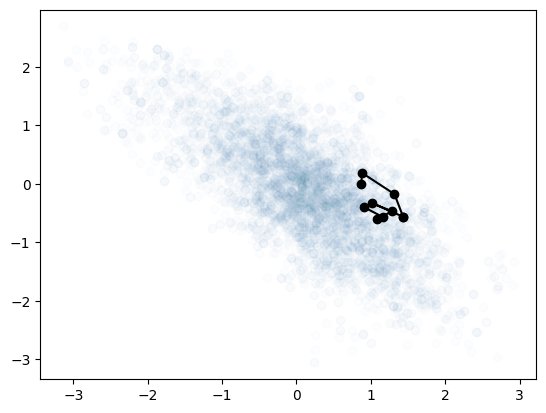

In [8]:
warmup = 5_000
idx = np.arange(M - warmup)
plt.scatter(thetas[warmup:, 0], thetas[warmup:, 1], alpha = 0.01)
plt.plot(thetas[warmup:warmup+10, 0], thetas[warmup:warmup+10, 1], color = "black");
plt.scatter(thetas[warmup:warmup+10, 0], thetas[warmup:warmup+10, 1], color = "black");

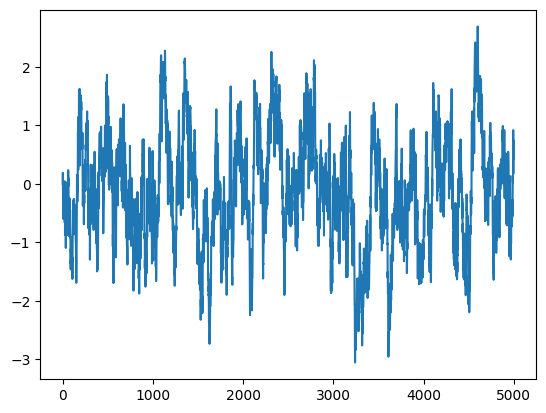

In [12]:
plt.plot(thetas[warmup:, 1]);

In [18]:
np.shape(np.unique(thetas[warmup:, :], axis = 0))

(3984, 2)

### HMC (on toy model)

In [13]:
def leapfrog_step(theta, rho, grad, data, stepsize):
    scale = data["scale"]
    rho2 = rho + 0.5 * stepsize * grad(theta, data)
    theta2 = theta + stepsize * scale * rho2
    rho2 += 0.5 * stepsize * scale * grad(theta2, data)
    return theta2, rho2

def leapfrog(theta, rho, grad, data, stepsize, numsteps):
    for _ in range(numsteps):
        theta, rho = leapfrog_step(theta, rho, grad, data, stepsize)
    return theta, rho

def hamiltonian(theta, rho, logf, data):
    scale = data["scale"]
    return logf(theta, data) - 0.5 * rho.T @ np.diag(scale) @ rho

def hmc_step(theta, logf, grad, data, stepsize, numsteps, rng):
    scale = data["scale"]
    rho = rng.normal(scale = scale, size = np.shape(theta))
    H = hamiltonian(theta, rho, logf, data)
    thetastar, rhostar = leapfrog(theta, rho, grad, data, stepsize, numsteps)
    Hstar = hamiltonian(thetastar, rhostar, logf, data)
    r = np.minimum(0, Hstar - H)
    u = np.log(rng.uniform())
    if u < r:
        theta = thetastar
    return theta    

In [19]:
rng = np.random.default_rng()
M = 10_000
mu = np.zeros(2)
S = np.identity(2)
r = -0.75
S[0,1] = S[1,0] = r
data = {"r": r, "mu": mu, "S": S, "scale": np.ones(2)}
thetas = np.zeros(shape = (M, 2))
thetas[0] = rng.uniform(size = 2)
for m in range(1, M):
    thetas[m] = hmc_step(thetas[m-1], normal_ll, grad_normal_ll, data, 0.3, 7, rng)

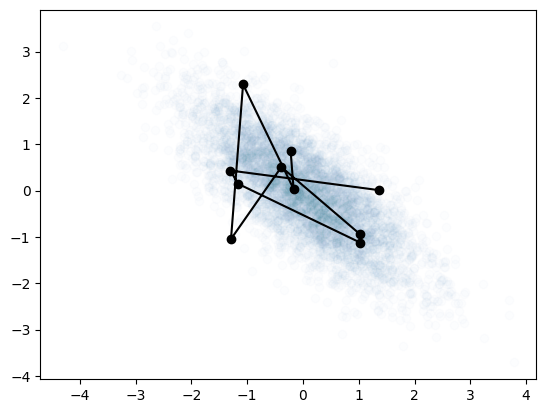

In [20]:
warmup = 5_000
idx = np.arange(M - warmup)
plt.scatter(thetas[warmup:, 0], thetas[warmup:, 1], alpha = 0.01)
plt.plot(thetas[warmup:warmup+10, 0], thetas[warmup:warmup+10, 1], color = "black");
plt.scatter(thetas[warmup:warmup+10, 0], thetas[warmup:warmup+10, 1], color = "black");

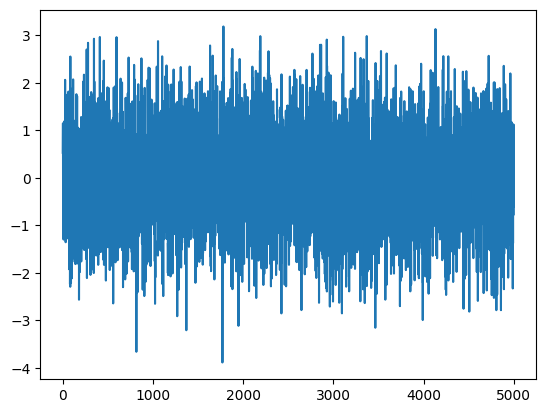

In [16]:
plt.plot(thetas[warmup:, 1]);

In [21]:
np.shape(np.unique(thetas[warmup:, :], axis = 0))

(4848, 2)

## Real World Model

We want to fit this model, but $\sigma > 0$.

$$f(\beta_0, \beta_1, \sigma | \mathbf{y}, \mathbf{x}) \propto \left(\prod_{n=1}^N \text{normal}(y_n | \beta_0 + \beta_1 \cdot x_n, \sigma) \right) \cdot \text{exponential}(\sigma | 1) \cdot \text{normal}(\beta_0|0, 1) \cdot \text{normal}(\beta_1 | 0, 1)$$

So we transform $\sigma$ to the real line.

$$f(\beta_0, \beta_1, \sigma | \mathbf{y}, \mathbf{x}) \propto \left(\prod_{n=1}^N \text{normal}(y_n | \beta_0 + \beta_1 \cdot x_n, \exp{(\sigma)}) \right) \cdot \text{exponential}(\exp{(\sigma)} | 1) \cdot \exp{(\sigma)} \cdot \text{normal}(\beta_0|0, 1) \cdot \text{normal}(\beta_1 | 0, 1)$$

Nonetheless, we still do all computations on the log scale.

$$\log{(f(\beta_0, \beta_1, \sigma))} \propto \left( \sum_{n=1}^N \log{(\text{normal}(y_n | \beta_0 + \beta_1 \cdot x_n, \exp{(\sigma)}))} \right) + \log{(\text{exponential}(\exp{(\sigma)} | 1) \cdot \exp{(\sigma)})} + \log{(\text{normal}(\beta_0|0, 1))} + \log{(\text{normal}(\beta_1 | 0, 1))}$$

where

$$\text{normal}(y | \mu, \sigma) = (2 \pi \sigma^2)^{-1/2} e^{-(y - \mu)^2 / (2\sigma^2)}$$

and

$$\text{exponential}(x | \lambda) = \lambda e^{-\lambda \cdot x}$$

In [16]:
def lm(theta, X):
    beta = theta[:-1]
    return X @ beta

$$\log{(f(\beta_0, \beta_1, \sigma))} \propto - N \sigma - 0.5 e^{-2\sigma} \sum_{n=1}^N (y_n - (\beta_0 + \beta_1 x_n))^2 - e^{\sigma} + \sigma - 0.5 \beta_0^2 - 0.5 \beta_1^2$$

$$\nabla \log{(f(\beta_0, \beta_1, \sigma))} = \left(\frac{d\log{(f)}}{d\beta_0}, \frac{d\log{(f)}}{d\beta_1}, \frac{d\log{(f)}}{d\sigma}\right)^T$$

In [17]:
df = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/refs/heads/master/finches.csv")
y, X = pt.dmatrices("winglength ~ middletoelength", data = df)

In [ ]:
rng = np.random.default_rng()
M = 10_000
scale = np.array([0.62381791, 0.03323834, 0.0074003 ])
data = {"X": X, "y": y[:,0], "scale": scale}
thetas = np.zeros(shape=(M, 3))
thetas[0] = np.array([0.7, 3.7, 1.3])
for m in range(1, M):
    thetas[m] = hmc_step(thetas[m-1], posterior, posterior_grad, data, 0.21, 8, rng)